## Обработка таблицы "Orders"

In [7]:
import pandas as pd
import arrow 
from tqdm import tqdm
import pickle

In [11]:
data = pd.read_csv('data/orders.csv')

In [37]:
d0 = pd.read_csv('data/normalized_df.csv')
d0 = d0.drop('Unnamed: 0', axis=1)
# d0 = d0.drop('Unnamed: 0.1', axis=1)
d0

,delivery_area_id,date,orders_cnt,hour,weekday,orders_cnt_normalized,orders_cnt_finally_normalized
0,0,2021-04-01 10:00:00,9,10,3,2.0,4.50
1,0,2021-04-01 11:00:00,1,11,3,2.0,0.50
2,0,2021-04-01 13:00:00,1,13,3,2.0,0.50
3,0,2021-04-01 14:00:00,1,14,3,2.0,0.50
4,0,2021-04-01 15:00:00,2,15,3,2.0,1.00
...,...,...,...,...,...,...,...
884851,592,2021-11-30 16:00:00,6,16,1,4.0,1.50
884852,592,2021-11-30 17:00:00,3,17,1,4.0,0.75
884853,592,2021-11-30 18:00:00,2,18,1,0.0,0.00
884854,592,2021-11-30 19:00:00,4,19,1,0.0,0.00


In [41]:
#orders_cnt_normalized - медиана предыдущей недели
#orders_cnt_finally_normalized - нормированное количестов заказов
d0.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,delivery_area_id,orders_cnt,hour,weekday,orders_cnt_normalized,orders_cnt_finally_normalized,isHoliday,beforeHoliday
delivery_area_id,1.00,-0.27,-0.00,0.00,-0.32,0.03,-0.05,0.05
orders_cnt,-0.27,1.00,-0.03,0.04,0.80,0.29,0.02,-0.13
hour,-0.00,-0.03,1.00,-0.01,0.00,-0.05,-0.00,-0.00
weekday,0.00,0.04,-0.01,1.00,0.05,0.00,0.03,0.00
orders_cnt_normalized,-0.32,0.80,0.00,0.05,1.00,-0.15,0.02,-0.16
orders_cnt_finally_normalized,0.03,0.29,-0.05,0.00,-0.15,1.00,-0.00,0.03
isHoliday,-0.05,0.02,-0.00,0.03,0.02,-0.00,1.00,-0.24
beforeHoliday,0.05,-0.13,-0.00,0.00,-0.16,0.03,-0.24,1.00


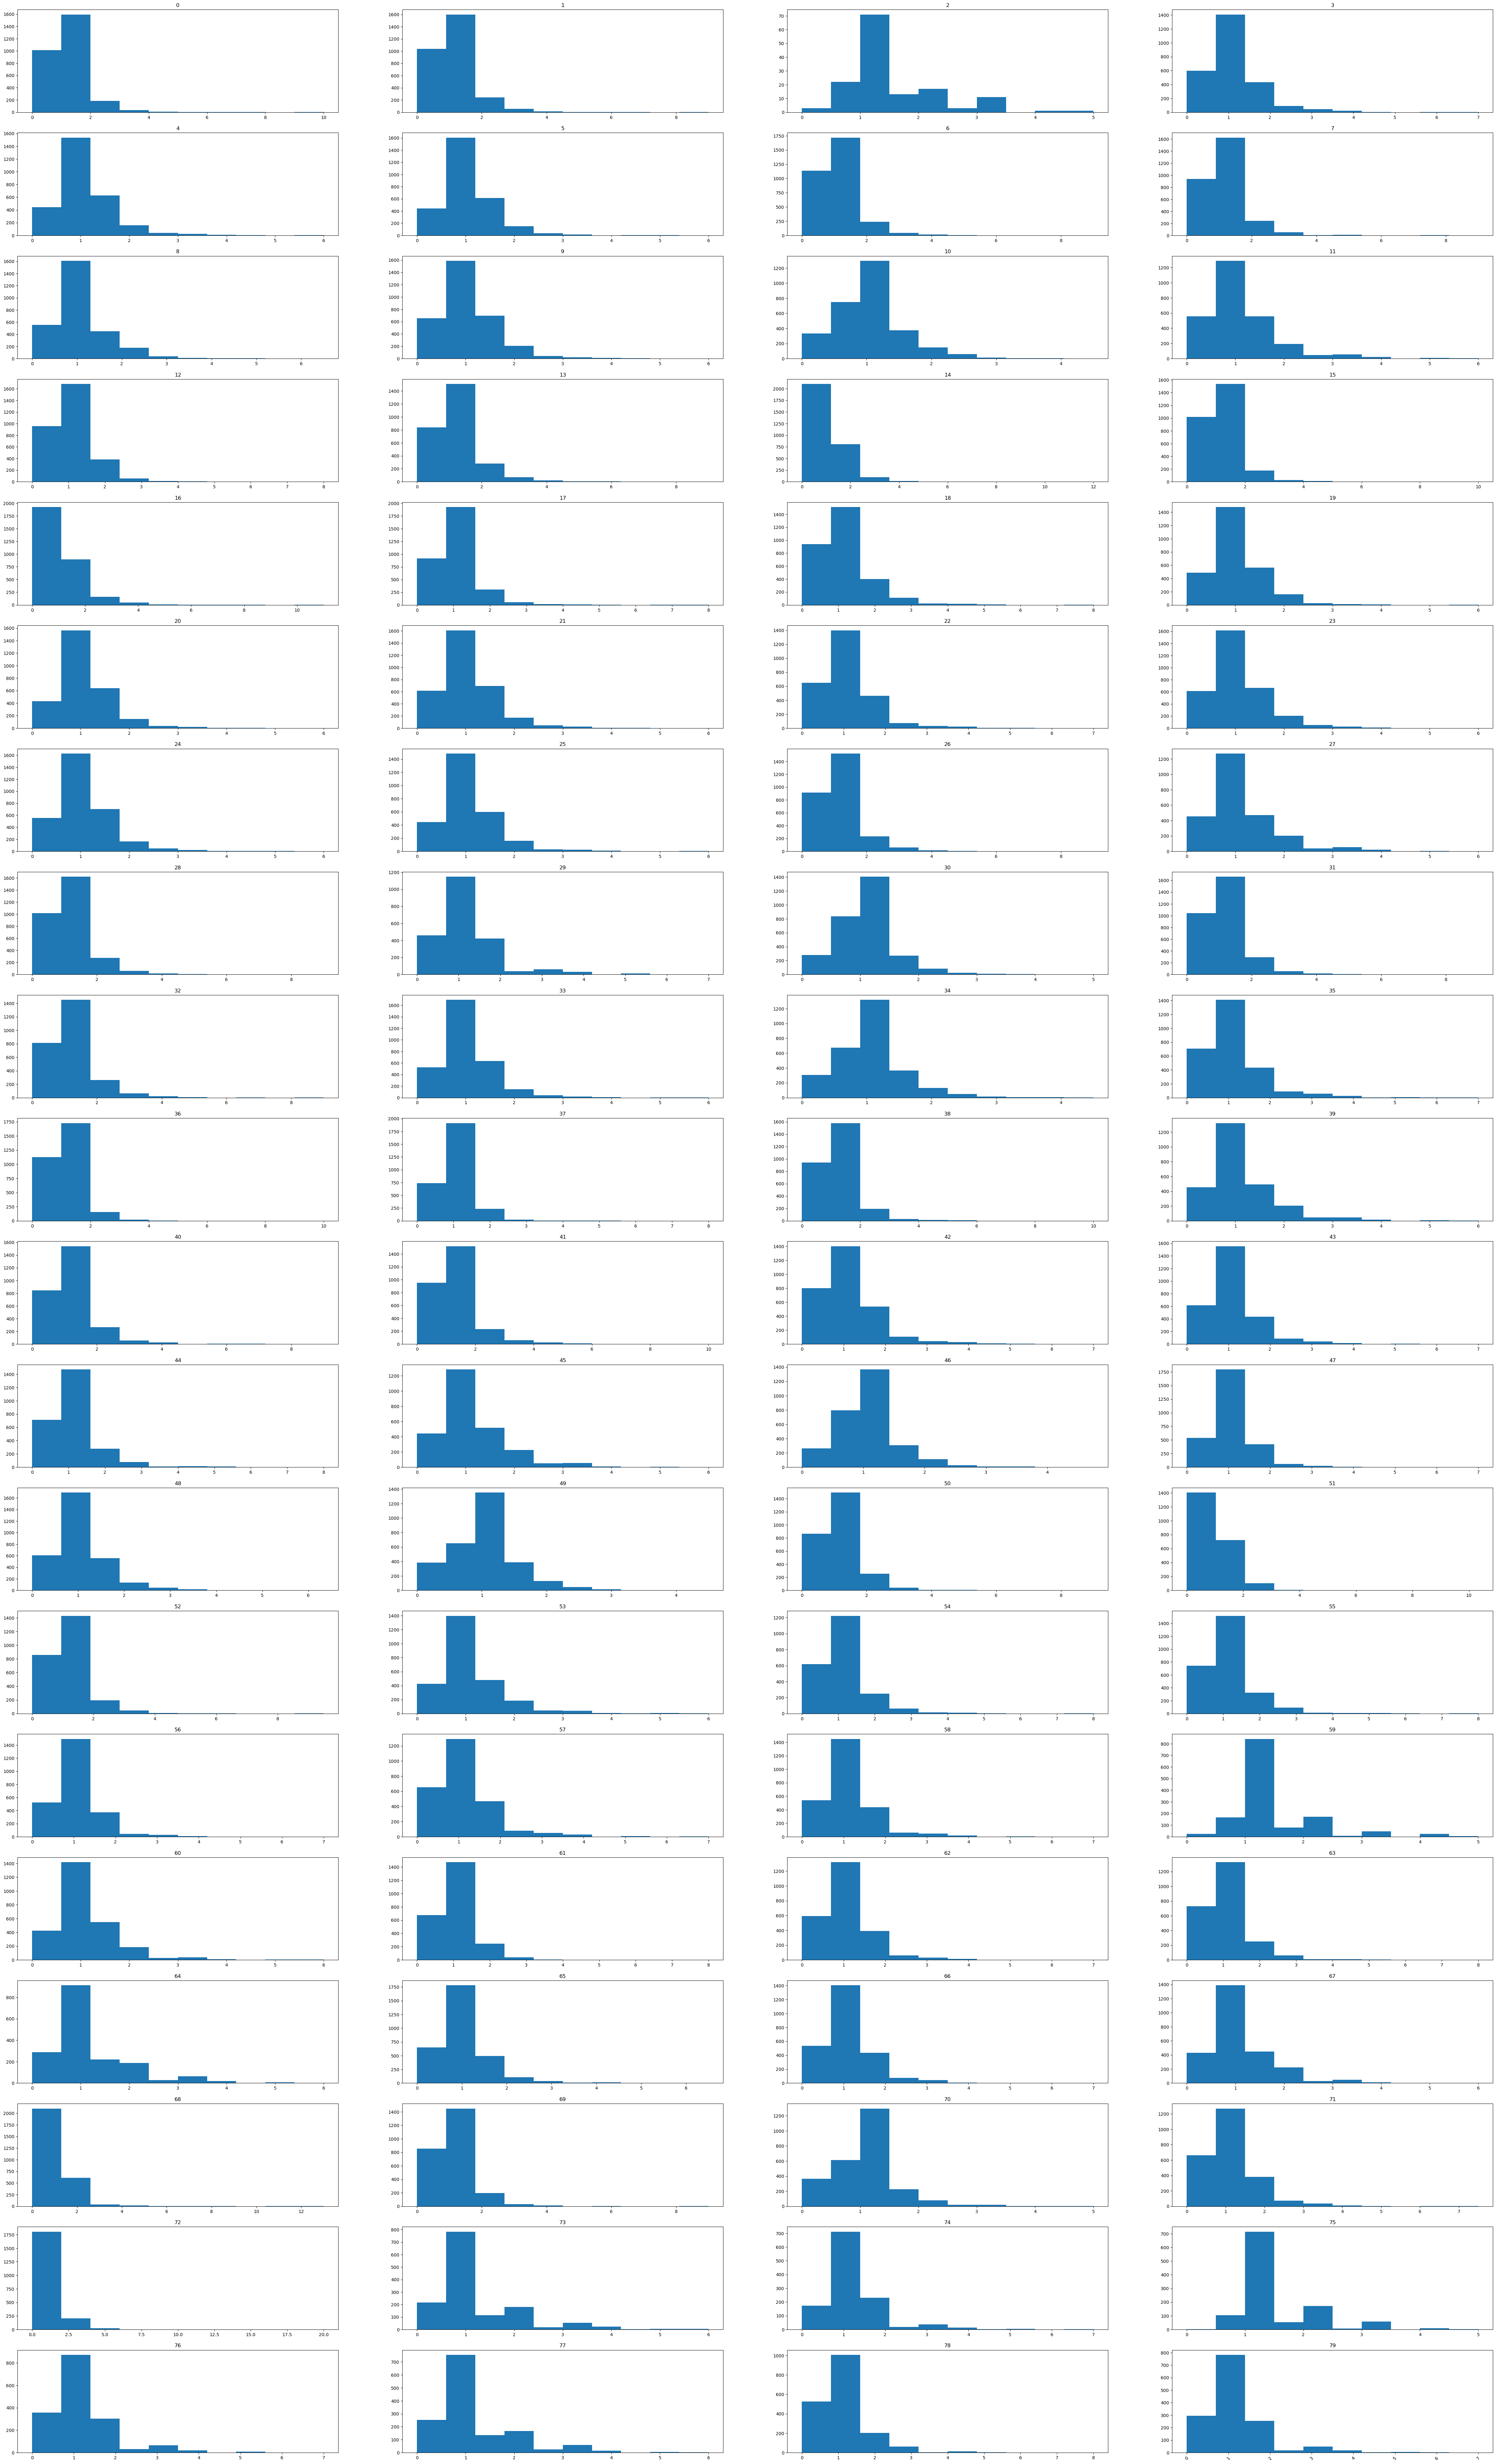

In [39]:
fig, axes = plt.subplots(20, 4, figsize=(60, 100))
axes = axes.ravel()
for i, ax in enumerate(axes):
    try:
        ax.hist(d0.loc[d0.delivery_area_id==d0.delivery_area_id.unique()[i]].orders_cnt_finally_normalized)
        ax.set_title(d0.delivery_area_id.unique()[i])
        plt.xticks(rotation=45)
    except IndexError:
        continue

In [38]:
d0 = data.copy()

Достанем из столбца даты час и день недели

In [13]:
holidays_list = pd.Series(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08', '2018-02-23',
                 '2018-03-08', '2018-03-09', '2018-04-30', '2018-05-01', '2018-05-02', '2018-05-09', '2018-06-11',
                 '2018-06-12', '2018-11-05', '2018-12-31', '2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
                 '2019-01-07', '2019-01-08', '2019-03-08', '2019-05-01', '2019-05-02', '2019-05-03', '2019-05-09',
                 '2019-05-10', '2019-06-12', '2019-11-04', '2019-12-31', '2020-01-01', '2020-01-02', '2020-01-03',
                 '2020-01-06', '2020-01-07', '2020-01-08', '2020-02-24', '2020-03-09', '2020-05-01', '2020-05-04',
                 '2020-05-05', '2020-05-11', '2020-06-12', '2020-11-04', '2020-12-31', '2021-01-01', '2021-01-04',
                 '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-02-22', '2021-02-23', '2021-03-08',
                 '2021-05-03', '2021-05-04', '2021-05-05', '2021-05-10', '2021-06-14', '2021-11-04', '2021-11-05',
                 '2021-12-31', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-02-23',
                 '2022-03-07', '2022-03-08', '2022-05-02', '2022-05-03', '2022-05-09', '2022-05-10', '2022-06-13',
                 '2022-11-04'])
holidays_list = holidays_list.apply(lambda x: arrow.get(x).format('MM-DD'))

In [38]:
d0['date']=d0['date'].apply(lambda x: arrow.get(x).datetime)
d0['date']=pd.to_datetime(d0['date'])
d0['hour'] = d0.date.dt.hour
d0['weekday'] = d0.date.dt.weekday.astype(int)
d0['isHoliday'] = d0.date.apply(lambda x: arrow.get(x).format('MM-DD')).isin(holidays_list)*1
Filtered_holidays = holidays_list.apply(lambda x: arrow.get('2000-'+x).datetime)
d0['beforeHoliday'] = d0.date.apply(lambda x:abs(Filtered_holidays-arrow.get('2000-'+arrow.get(x).format('MM-DD')).datetime).dt.days.min())

KeyboardInterrupt: 

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd 
from sklearn.metrics import *
from catboost import CatBoostClassifier, CatBoostRegressor
import numpy as np
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
warnings.filterwarnings('ignore')
import pickle

## Сделаем прогноз для 7 дней недели и всех регионов
(Добавим строку с метрикой MAPE)

In [119]:
X_train

,hour,isHoliday,beforeHoliday
1739,18,0.0,66.0
1246,17,0.0,35.0
830,15,1.0,0.0
1406,12,0.0,49.0
1487,11,0.0,56.0
...,...,...,...
502,15,0.0,6.0
746,14,0.0,4.0
1902,14,0.0,52.0
2409,21,0.0,10.0


In [30]:
d_train = d_temp.loc[d0.weekday==0]
X_train, X_test, y_train, y_test = train_test_split(d_train.drop(['date','orders_cnt','delivery_area_id', 'weekday', 'orders_cnt_normalized', 'orders_cnt_finally_normalized','beforeHoliday'], axis=1), d_train['orders_cnt_finally_normalized'], test_size=0.33, random_state=42)

In [28]:
params = {'iterations': [100, 500, 1000, 2000], 'learning_rate': [0.03, 0.1, 0.3], 'depth': [3, 5,8], 'l2_leaf_reg': [3, 10], 'loss_function': ['MAPE']}

In [ ]:
catboost_best_grid = GridSearchCV(CatBoostRegressor(verbose=0), params).fit(X_train, y_train)
y_pred0 = catboost_model.predict(X_test)

In [ ]:
print(catboost_best_grid.best_params_)

{'depth': 3, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'loss_function': 'MAPE'}


In [ ]:
catboost_model = CatBoostRegressor(depth=3, iterations=1000, l2_leaf_reg=3, learning_rate=0.03, loss_function='MAPE', verbose=0).fit(X_train, y_train)
y_pred0 = catboost_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred0))

In [ ]:
mon_sum_pred = pd.DataFrame()
for k in range(0, 7):
    locals()['sum_pred'+str(k)]=pd.DataFrame()
    locals()['MAPE'+str(k)]=pd.DataFrame()
    for i in range(8, 24):
            mon_sum_pred.loc[i, 'hour']=int(i)
            mon_sum_pred.loc[i, 'isHoliday']=int(0)
            mon_sum_pred.loc[i, 'beforeHoliday']=int(18)
    for j in tqdm(data.delivery_area_id.unique()):
        d_temp = d0.loc[d0.delivery_area_id==j]
        d_train = d_temp.loc[d0.weekday==k]
        X_train, X_test, y_train, y_test = train_test_split(d_train.drop(['date','orders_cnt','delivery_area_id', 'weekday', 'orders_cnt_normalized', 'orders_cnt_finally_normalized'], axis=1), d_train['orders_cnt_finally_normalized'], test_size=0.33, random_state=42)
        # params = {'n_estimators': 2000, 'verbose': -1}
        # params_fit = {'X': X_train, 'y': y_train, 'eval_set': (X_test, y_test), 'verbose': False, 'early_stopping_rounds':5}
        # gbm = lgb.LGBMRegressor(metric='mape', **params)
        # gbm.fit(**params_fit)
        # locals()['sum_pred'+str(k)]['predict'+str(j)]=gbm.predict(pd.DataFrame(mon_sum_pred.hour))
        # y_pred0 = gbm.predict(X_test)
        # locals()['MAPE'+str(k)].loc[0,'predict'+str(j)] = mean_absolute_percentage_error(y_test, y_pred0)
        catboost_model = CatBoostRegressor(depth=8, iterations=100, l2_leaf_reg=3, learning_rate=0.3, loss_function='MAPE', verbose=0).fit(X_train, y_train)        
        # catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test))
        
        locals()['sum_pred'+str(k)]['predict'+str(j)]=catboost_model.predict(pd.DataFrame(mon_sum_pred))
        y_pred0 = catboost_model.predict(X_test)
        locals()['MAPE'+str(k)].loc[0,'predict'+str(j)] = mean_absolute_percentage_error(y_test, y_pred0)

Сохраним файл с предиктами

In [246]:
for i in range(0, 7):
    with open('pickles/sum_pred'+str(i)+'.pickle', 'wb') as handle:
            pickle.dump(locals()['sum_pred'+str(i)], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [274]:
for i in range(0, 7):
    with open('pickles/MAPE'+str(i)+'.pickle', 'wb') as handle:
            pickle.dump(locals()['MAPE'+str(i)], handle, protocol=pickle.HIGHEST_PROTOCOL)

## Поиск оптимального отношения партнёров к количеству заказов

Загрузим данные из прошлого пункта

In [16]:
for i in range(0,7):
    with open('pickles/sum_pred'+str(i)+'.pickle', 'rb') as handle:
        locals()['sum_pred'+str(i)] = pickle.load(handle)

In [17]:
delays = pd.read_csv('data/partners_delays.csv')


Достанем из таблицы с партнёрами 200'000 строк

Добавим к ним характеристики количества заказов

In [18]:
d0['date']=pd.to_datetime(d0['date']).astype('datetime64[ns]')

In [19]:
delays['date'] = pd.to_datetime(delays['dttm'])
# delays['date']=delays['dttm']
delays0 = delays[:200000].drop('dttm', axis=1)
data0 = data
delays0 = delays0.merge(d0[:200000], on='date')[['partners_cnt', 'orders_cnt_finally_normalized', 'delay_rate']]

Найдём соотношение количества партнёров к количеству заказов

In [20]:
delays0['par_d_ord']=delays0.partners_cnt/delays0.orders_cnt_finally_normalized

In [21]:
delays0['isLate']=(delays0.delay_rate>0) * 1

Создадим вспомогательную переменную 

In [22]:
delays0 = delays0.loc[delays0.isLate==0]

In [25]:
delays0 = delays0.loc[delays0.par_d_ord!=np.inf]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(delays0.orders_cnt_finally_normalized), pd.DataFrame(delays0.par_d_ord), test_size=0.33, random_state=0)

Натренируем LGMRegressor на 200'000 строк<br>
Анализ по - количество заказов<br>
Целевая пременная - соотношение количества партнёров к количеству заказов.<br>

In [34]:
params = {'n_estimators': 2000, 'verbose': -1}
params_fit = {'X': X_train, 'y': y_train, 'eval_set': (X_test, y_test), 'verbose': False, 'early_stopping_rounds':5}
gbm = lgb.LGBMRegressor(**params, metrics='auc')
gbm.fit(**params_fit)

LGBMRegressor(metrics='auc', n_estimators=2000, verbose=-1)

In [27]:
y_test = y_test.apply(lambda x: x.replace(np.inf, 0))

In [28]:
catboost_model = CatBoostRegressor(depth=4, iterations=500, learning_rate=0.03, loss_function='MAPE', verbose=0).fit(X_train, y_train)

0:	learn: 0.5270242	total: 1.41s	remaining: 11m 41s
1:	learn: 0.5240381	total: 2.75s	remaining: 11m 25s
2:	learn: 0.5211564	total: 3.94s	remaining: 10m 53s
3:	learn: 0.5183720	total: 5.1s	remaining: 10m 32s
4:	learn: 0.5158542	total: 6.36s	remaining: 10m 29s
5:	learn: 0.5134199	total: 7.75s	remaining: 10m 38s
6:	learn: 0.5109161	total: 8.96s	remaining: 10m 30s
7:	learn: 0.5085464	total: 10.1s	remaining: 10m 19s
8:	learn: 0.5063687	total: 11.3s	remaining: 10m 15s
9:	learn: 0.5042679	total: 12.4s	remaining: 10m 6s
10:	learn: 0.5022237	total: 13.5s	remaining: 9m 58s
11:	learn: 0.5001631	total: 14.6s	remaining: 9m 53s
12:	learn: 0.4982006	total: 15.7s	remaining: 9m 48s
13:	learn: 0.4967937	total: 17s	remaining: 9m 50s
14:	learn: 0.4955996	total: 18.1s	remaining: 9m 45s
15:	learn: 0.4944595	total: 19.3s	remaining: 9m 42s
16:	learn: 0.4933741	total: 20.4s	remaining: 9m 39s
17:	learn: 0.4923398	total: 21.6s	remaining: 9m 37s
18:	learn: 0.4913633	total: 22.7s	remaining: 9m 35s
19:	learn: 0.490

In [30]:
y_pred0 = catboost_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred0))

Сделаем предикт для всех дней недели, всех регионов

In [31]:
for j in tqdm(range(0, 7)):
    locals()['count_wod'+str(j)]=pd.DataFrame()
    # locals()['MAPE_count'+str(k)]=pd.DataFrame()
    train_df = locals()['sum_pred'+str(j)]
    for i in train_df.columns:
        temp_df=pd.DataFrame()
        temp_df['orders_cnt_finally_normalized']=train_df[i]
        locals()['count_wod'+str(j)][i] = catboost_model.predict(temp_df)
        # y_pred0 = catboost_model.predict(temp_df)
        # locals()['MAPE_count'+str(k)].loc[0,'predict'+str(j)] = mean_absolute_percentage_error(y_test, y_pred0)

100%|██████████| 7/7 [00:31<00:00,  4.44s/it]


Сохраним файл с предиктами

In [32]:
for i in range(0, 7):
    with open('pickles/count_wod'+str(i)+'.pickle', 'wb') as handle:
            pickle.dump(locals()['count_wod'+str(i)], handle, protocol=pickle.HIGHEST_PROTOCOL)